# NP08 Analysis Template

Welcome to the NP08 Analysis Scripts

Dummy values (10000 and -10000) have been assigned to all variables which students would typically change. 

However, don't be scared of the code and play around with it - This is an experimental lab after all...

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

FileName = 'runD_999999.dat'

### Note about the structure of the data:

Each line in the file represents the data from one trigger of the oscilloscope.  When it triggers, data are collected from 250 ticks before and 2250 ticks after the trigger time. The timebase is on setting 3 which is 8ns per tick, so this time window represents 20microseconds.

The picoscope has a somewhat novel, and rather nice way of formatting the analogue-to-digital convesion values (ADC values).  The ADC values are always given in a 16-bit range, i.e. from -32768 to +32767 even if the ADC is set to a lower resolution, in which case the lower bits are zero and the ADC values jump by the appropriate power of 2 (for 12 bits, which is our usual, this is jumps of 16 (2^(16-12)).  This means that if we change the resolution, we don't have to rewrite the code.  The SDKprogram setting menu prints the ADC count and milliVolt ranges, and this is easiest way to get the conversion factor if you need it.

The detectors are labelled as in the script as A, B, C from top to bottom, so the big one the muons stop in is counter B.  They are attached to oscillsocope channels A, B and C respectively.   Usually, the scale of the A and C channels are set to 500mV, so ADC +32767 = +250mV and ADC =32768 = -250mV (The B counter us usually set to a scale of 2V.  The baseline is at 0 ADC counts and pulses are negative.  There is a hardware trigger (called 'cut 1' below) which results in an 'event' or 'capture' being taken.  The hardware trigger is when channel B goes below -1000 ADC counts (about -61mV), falling edge [The K setting in SDKprogram].  The data are collected in groups of 1000 triggers and transferred to the computer.  One group takes about one second, so the triggers are about 1ms apart on average.

The computer looks at each capture of data and identifies four pulses if they are there. It first looks for the B1 pulse (the peak in the waveform above a threhsold on counter B that is nearest to the trigger time), then for a pulse on the A channel (the A1 pulse) that is nearest the B1 pulse time, then a pulse on channel C (the C1 pulse) that is nearest the B1 time.  Then it looks for a second pulse on the B channel (the B3 pulse).  It took several attempts to develop a good selection algorithm for this pulse, which is why there are other attempts that you do not need to look at (B2,B4,B5,B6).  For interest, the succesful algorithm is that B3 is the largest pulse (from a baseline immediately before the pulse to it's peak) that is at least 50 ticks after the B1 time.  For all the pulses, the time of arrival of the pulse is the time when it goes over the threshold (the A,B,C,D settings in SDKprogram).

### Read data to PANDAS dataframe - here is where you give the filename

Now we can get going and form the [pandas dataframe](https://pandas.pydata.org) by reading from a csv file all the columns specified in the list `columns` into a dataframe called df_inp. This will take a few seconds then the `head()` command will show you the first 5 entries in the dataframe (or N rows if you enter `head(N)`), a useful tool to check things are sensible. Note that we can check how many events were recorded by printing out the length of df_inp.  Since we are not interested in some of the variables that were needed for the early development, we next make a dataframe df_raw with just the interesting variables.  We are intending to modify the SDKprogram to write only these variables to make the input files smaller.   

In [3]:
# Read in the data.  columns_raw assigns the names to the columns in the input file  
columns_inp = ["group", "capture", "flagall", \
           "flaga1", "flagb1", "flagc1", "flagd1", \
           "timea1", "timeb1", "timec1", "timed1", \
           "dtimea1", "dtimeb1", "dtimec1", "dtimed1", \
           "peaka1", "peakb1", "peakc1", "peakd1", \
           "flagb3", "flagb4", "flagb5", "flagb6", \
           "timeb3", "timeb4", "timeb5", "timeb6", \
           "dtimeb3", "dtimeb4", "dtimeb5", "dtimeb6", \
           "peakb3", "peakb4", "peakb5", "peakb6", \
           "baseb3", "baseb4", "baseb5", "baseb6", \
           "endtimeb3", "endtimeb4", "endtimeb5", "endtimeb6"]

DFinp = pd.read_csv(FileName, header=0, names=columns_inp, sep=',', quotechar='"')

print("Number of events in DFinp: ",len(DFinp))

# Make a dataframe with just the interesting variables
columns = [
            "flaga1", "dtimea1", "peaka1",  \
            "flagb1", "dtimeb1", "peakb1",  \
            "flagc1", "dtimec1", "peakc1",  \
            "flagb3", "dtimeb3", "peakb3",  \
            "flagd1", "dtimed1", "peakd1"]
DFraw = DFinp[columns]

print("Number of events in DFraw (Dataframe of interest): ",len(DFraw))
DFraw.head()

Number of events in DFinp:  6272320
Number of events in DFraw (Dataframe of interest):  6272320


,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
0,1,1686.59,-1437,1,250.35,-2213,0,0.00,0,0,0.0,0,0,0.0,0
1,1,2429.87,-1163,1,250.11,-4249,1,737.85,-1126,0,0.0,0,0,0.0,0
2,1,1323.69,-1437,1,250.38,-1427,0,0.00,0,0,0.0,0,0,0.0,0
3,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.9,-1123,0,0.0,0
4,1,1569.69,-1276,1,251.19,-1716,0,0.00,0,0,0.0,0,0,0.0,0


### Analysis - calculate delta time variables

#### Calculate Variables in New Columns

To insert columns use the `insert()` method ([insert() documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html)), in the form below the column will be added just beside the index and move all other columns to the right.  We add here the time differences between the various pulses in the event which will be useful in the cuts below.

In [4]:
#insert columns for the time difference between pulses in different layers of the detector.
DFraw.insert(0, 'delta_t_a1b1', (DFraw['dtimea1']-DFraw['dtimeb1']), True)
DFraw.insert(1, 'delta_t_c1a1', (DFraw['dtimec1']-DFraw['dtimea1']), True)
DFraw.insert(2, 'delta_t_c1b1', (DFraw['dtimec1']-DFraw['dtimeb1']), True)
DFraw.insert(3, 'delta_t_b3a1', (DFraw['dtimeb3']-DFraw['dtimea1']), True)

DFraw.head() 

,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
0,1436.24,-1686.59,-250.35,-1686.59,1,1686.59,-1437,1,250.35,-2213,0,0.00,0,0,0.0,0,0,0.0,0
1,2179.76,-1692.02,487.74,-2429.87,1,2429.87,-1163,1,250.11,-4249,1,737.85,-1126,0,0.0,0,0,0.0,0
2,1073.31,-1323.69,-250.38,-1323.69,1,1323.69,-1437,1,250.38,-1427,0,0.00,0,0,0.0,0,0,0.0,0
3,-1.56,0.61,-0.95,76.29,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.9,-1123,0,0.0,0
4,1318.50,-1569.69,-251.19,-1569.69,1,1569.69,-1276,1,251.19,-1716,0,0.00,0,0,0.0,0,0,0.0,0


## Analysis Strategy

For the main data taking, there are a selection of cuts that are made on the data.  These are:

-  **Cut 1:** Require a pulse on the B counter (this is implemented as the scope trigger => read 20us window of data into memory)
-   **Cut 2:** Require a pulse on the A counter (this is implemented in software, a pulse anywhere in the 20us window on A means this cut passes)
-   **Cut 3:** Require a tighter requirement on the time between the A and B pulse.
-   **Cut 4:** Veto.  Reject the event if there is a pulse on C in coincidence with A & B
-   **Cut 5:** Require that a ‘preferred’ second pulse was found on B i.e. that flagB3=1 (reject the ones with flagB3=2).  The trickiest part when we were setting up is to reject after pulsing background i.e. where there is no second detected particle, but the B counter after pulses. 
-   **Cut 6:** Place a requirement on the heights of the pulses A, B1 and B3.  The most effective we found is to cut on peakB3.




### Cut1 and Cut2

Cuts can be applied in several ways but the core point is here that we keep rows (i.e. events) based on some logical condition.  We will do the six cuts descibed above and make a new dataframe at each step.  We will describe below that we want the program to be able to make three separate samples as we go through, however cuts 1 and 2 are the same for all of them, so we will do those first.   

Cut1 and Cut2 are 'trivial' because they were done already when the data were collected, but we do them again here to give a first example of making a cut with a data frame.  The sample after the cut is placed in a new data frame called DFcut2.

In [5]:
print("Number of events before Cut1&2:", len(DFraw))

DFcut1 = DFraw.loc[(DFraw['flagb1'] == 1)]
DFcut2 = DFcut1.loc[(DFcut1['flaga1'] == 1)]

print("Number of events after Cut1:", len(DFcut1))
print("Number of events after Cut2:", len(DFcut2))
DFcut2.head()

Number of events before Cut1&2: 6272320
Number of events after Cut1: 5922597
Number of events after Cut2: 5922597


,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
0,1436.24,-1686.59,-250.35,-1686.59,1,1686.59,-1437,1,250.35,-2213,0,0.00,0,0,0.0,0,0,0.0,0
1,2179.76,-1692.02,487.74,-2429.87,1,2429.87,-1163,1,250.11,-4249,1,737.85,-1126,0,0.0,0,0,0.0,0
2,1073.31,-1323.69,-250.38,-1323.69,1,1323.69,-1437,1,250.38,-1427,0,0.00,0,0,0.0,0,0,0.0,0
3,-1.56,0.61,-0.95,76.29,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.9,-1123,0,0.0,0
4,1318.50,-1569.69,-251.19,-1569.69,1,1569.69,-1276,1,251.19,-1716,0,0.00,0,0,0.0,0,0,0.0,0


We are going to study two samples of events, through going muons and then stopping muons.  Later we will also study uncorrelated background with a third sample derived from the stopping muons.  It will be very helpful to interleave these cuts for later (to make sure we do the same cuts to each sample), but it makes it a bit more complicated to read this at first. The variable names are DFScut... = Stopping, DFTcut... = Through-going, DFUcut... = Uncorrelated.  Start by focussing on the through-going sample.

### Cut3

We will leave you to decide the optimum values for cut3, but have supplied the code to do it with dummy values (-10000 and 10000).  Use the DFT variables while studying the through going muons and the DFS variables when studying the stopping muons.  See the script for using the DFU variables, for now the DFU cuts should be kept the same as the DFS ones.

- T - Through-going Muons
- S - Stopping Muons
- U - Uncorrelated noise

PANDAS trick: Note on the right hand side of the statement that makes the cut, the same dataframe name, DFcut2, is used in the inside and outside parts of all the PANDAS brackets on the right hand side.  That is important.

Cut3 is to make a time window cut on the coincidence between the A1 and B1 pulses. It is a cut to remove background due to random coincidences in the counters.  

If you have time to come back later, here are some suggested side-studies (we have not tried all these yet)): 
1.  Can you demonstrate that the random-coincidence background increases if you make the window wider? 
2.  You can get a sample of random coincidence background events by moving the window to be delibrately off-time.
3.  You measured the rate of counter A and B yesterday as a function of the pulse height threshold.  Explain why the coincidence window Rate(AB) = Rate(A).Rate(B).Win where Win is the length of the coincidence window used (in units of seconds if the rates are in Hz).  Try this with the data.  You may need to apply software cuts on the pulse heights here?   

Number of events before Cut3: 5922597


Number of events after Cut3 (T): 5922597
Number of events after Cut3 (S): 5922597
Number of events after Cut3 (U): 4750426


,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
0,1436.24,-1686.59,-250.35,-1686.59,1,1686.59,-1437,1,250.35,-2213,0,0.00,0,0,0.0,0,0,0.0,0
1,2179.76,-1692.02,487.74,-2429.87,1,2429.87,-1163,1,250.11,-4249,1,737.85,-1126,0,0.0,0,0,0.0,0
2,1073.31,-1323.69,-250.38,-1323.69,1,1323.69,-1437,1,250.38,-1427,0,0.00,0,0,0.0,0,0,0.0,0
3,-1.56,0.61,-0.95,76.29,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.9,-1123,0,0.0,0
4,1318.50,-1569.69,-251.19,-1569.69,1,1569.69,-1276,1,251.19,-1716,0,0.00,0,0,0.0,0,0,0.0,0


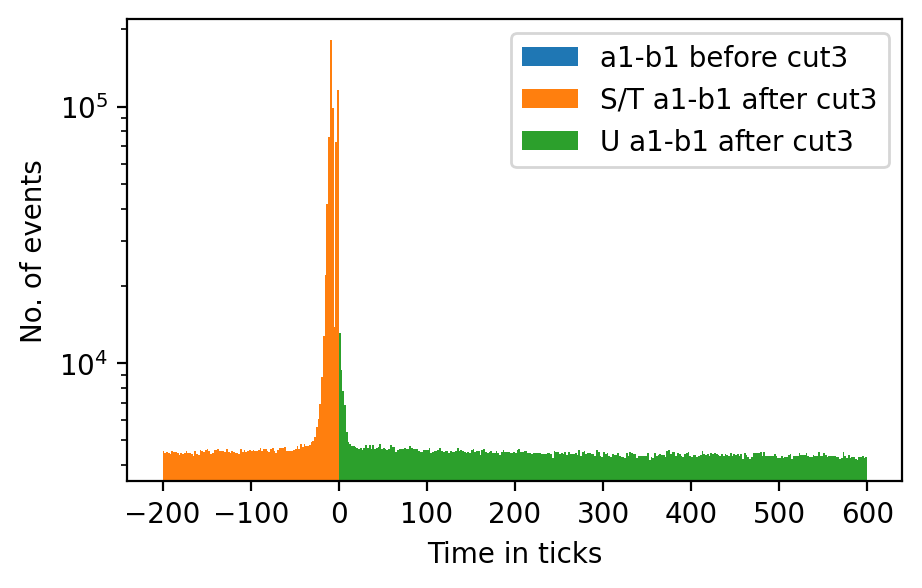

In [6]:
# We leave you to implement this cut, but provide a template with the cut 
# values set very large.  This means for now, we just copy the dataframe 
# DFcut2 to DFTcut3, DFScut3 and DFUcut3 so all the later variables work.  
# This is the point where we make the three branches of variables: DFS, T and U. 

LowerLimit = -10000
HigherLimit = 10000
UOffset = 10000

#T Cuts
DFTcut3 = DFcut2.loc[(DFcut2['delta_t_a1b1']>LowerLimit) & (DFcut2['delta_t_a1b1']<HigherLimit)]
#S Cuts
DFScut3 = DFcut2.loc[(DFcut2['delta_t_a1b1']>LowerLimit) & (DFcut2['delta_t_a1b1']<HigherLimit)]
#U Cuts
DFUcut3 = DFcut2.loc[(DFcut2['delta_t_a1b1']>LowerLimit+UOffset) & (DFcut2['delta_t_a1b1']<HigherLimit+UOffset)]

# Plotting and printing - none of the code in the rest of this box affects the cuts later.
# You can add more histograms in the plot or add more plots by copy-pasting
# Beware, set the range value to be the same for all the histograms you are drawing on one plot, otherwise it is very confusing (I know!).
plt.figure(figsize=(5,3), dpi=200)
DFcut2['delta_t_a1b1'].plot.hist(bins=400, range=[-200, 600], label='a1-b1 before cut3', logy=True)
DFTcut3['delta_t_a1b1'].plot.hist(bins=400, range=[-200, 600], label='S/T a1-b1 after cut3', logy=True)
DFUcut3['delta_t_a1b1'].plot.hist(bins=400, range=[-200, 600], label='U a1-b1 after cut3', logy=True)
plt.xlabel('Time in ticks')
plt.ylabel('No. of events')
plt.legend()

print("Number of events before Cut3:",len(DFcut2))
print("\n")
print("Number of events after Cut3 (T):",len(DFTcut3))
print("Number of events after Cut3 (S):",len(DFScut3))
print("Number of events after Cut3 (U):",len(DFUcut3))

DFTcut3.head()

### Cut4

For the through going sample, we want to see a coincidence of the C counter with the rest of the pulses.  Like with cut 3, the values in the template are very wide and you should narrow them.

For the stopping muon sample, we want to veto if the C counter has a hit on it in time with the A and/or B counters.  This is a bit awkward to express in code with dataframes, so we have done it already below, and the cut is reasonably optimal (but feel free to tweak).


Number of events before Cut4 (T): 5922597
Number of events before Cut4 (S): 5922597
Number of events before Cut4 (U): 4750426


Number of events after Cut4 (T): 5922597
Number of events after Cut4 (S): 5502973
Number of events after Cut4 (U): 4701179


,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
0,1436.24,-1686.59,-250.35,-1686.59,1,1686.59,-1437,1,250.35,-2213,0,0.00,0,0,0.0,0,0,0.0,0
1,2179.76,-1692.02,487.74,-2429.87,1,2429.87,-1163,1,250.11,-4249,1,737.85,-1126,0,0.0,0,0,0.0,0
2,1073.31,-1323.69,-250.38,-1323.69,1,1323.69,-1437,1,250.38,-1427,0,0.00,0,0,0.0,0,0,0.0,0
3,-1.56,0.61,-0.95,76.29,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.9,-1123,0,0.0,0
4,1318.50,-1569.69,-251.19,-1569.69,1,1569.69,-1276,1,251.19,-1716,0,0.00,0,0,0.0,0,0,0.0,0


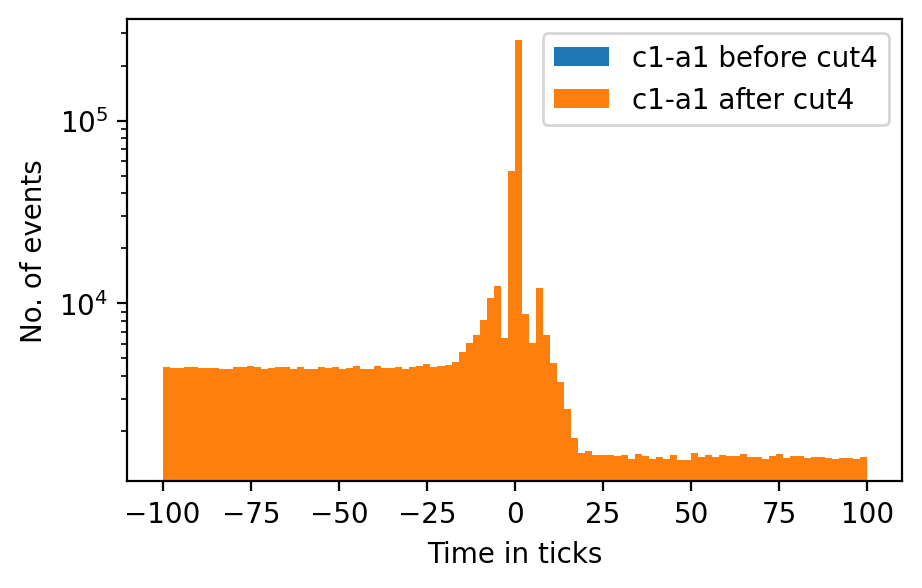

In [7]:
#Cut4, remove events where c1-a1 is less than 25 ticks apart or if C does not get a signal.
LowerLimit = -10000
UpperLimit = 10000

#T Cuts
DFTcut4 = DFTcut3.loc[(DFTcut3['delta_t_c1a1'] > LowerLimit) & (DFTcut3['delta_t_c1a1'] < UpperLimit)]
#S Cuts
DFScut4 = DFScut3.loc[(DFScut3['delta_t_c1a1'].abs() >= 25) | (DFScut3['flagc1'] == 0)]
#U Cuts
DFUcut4 = DFUcut3.loc[(DFUcut3['delta_t_c1a1'].abs() >= 25) | (DFUcut3['flagc1'] == 0)]

# Do some plotting to see if it looks OK (modify this yourself, or alter DFT to DFS to see how it affects the stopping sample)
plt.figure(figsize=(5,3), dpi=200)
DFTcut3['delta_t_c1a1'].plot.hist(bins=100, range=[-100, 100], label='c1-a1 before cut4', logy=True)
DFTcut4['delta_t_c1a1'].plot.hist(bins=100, range=[-100, 100], label='c1-a1 after cut4', logy=True)

plt.xlabel('Time in ticks')
plt.ylabel('No. of events')
plt.legend()

print("Number of events before Cut4 (T):",len(DFTcut3))
print("Number of events before Cut4 (S):",len(DFScut3))
print("Number of events before Cut4 (U):",len(DFUcut3))
print("\n")
print("Number of events after Cut4 (T):",len(DFTcut4))
print("Number of events after Cut4 (S):",len(DFScut4))
print("Number of events after Cut4 (U):",len(DFUcut4))

DFTcut4.head()

This next section is just another plot, no cutting. As before, you can swap the DFT to DFS variable names to look at the stopping muons, or make other combinations of plots or change the x-axis range as you like.

In [ ]:
#Plot the time differential between the three pulses
plt.figure(figsize=(5,3), dpi=200)
DFTcut4['delta_t_a1b1'].plot.hist(bins=100, alpha=0.5, label='a1-b1', range=[-100.0,500.0], logy=True) # histogram of 'd_time_a1b1' column
DFTcut4['delta_t_c1a1'].plot.hist(bins=100, alpha=0.5, label='c1-a1', range=[-100.0,500.0], logy=True)
DFTcut4['delta_t_c1b1'].plot.hist(bins=100, alpha=0.5, label='c1-b1', range=[-100.0,500.0], logy=True)

plt.xlabel('(T) Time in ticks')
plt.ylabel('No. of events')
plt.legend()

plt.savefig('TimeDifferences_T.png', dpi=200) # example code how to save a figure

plt.show()

Previous plot shows time for through-going muons. The below plot shows the same quantity for stopping muons

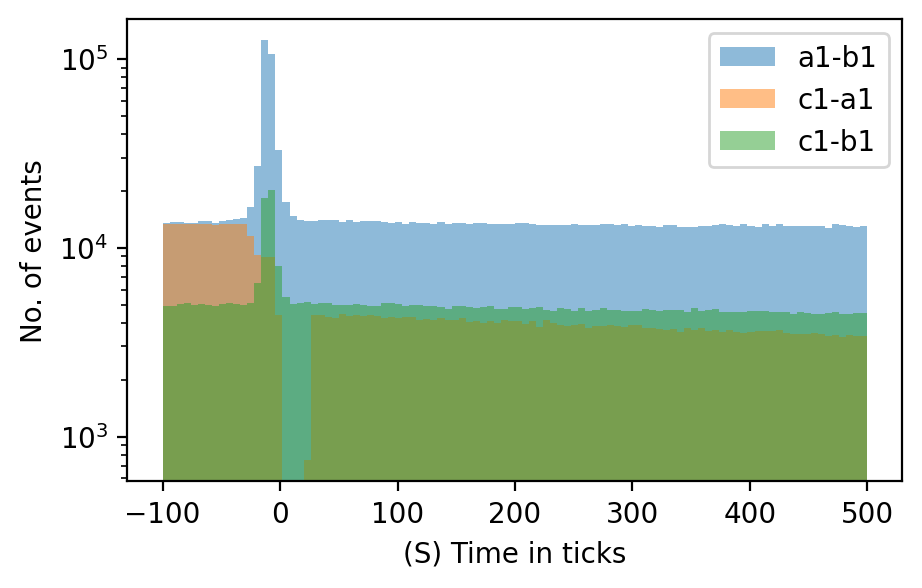

In [18]:
plt.figure(figsize=(5,3), dpi=200)
DFScut4['delta_t_a1b1'].plot.hist(bins=100, alpha=0.5, label='a1-b1', range=[-100.0,500.0], logy=True) # histogram of 'd_time_a1b1' column
DFScut4['delta_t_c1a1'].plot.hist(bins=100, alpha=0.5, label='c1-a1', range=[-100.0,500.0], logy=True)
DFScut4['delta_t_c1b1'].plot.hist(bins=100, alpha=0.5, label='c1-b1', range=[-100.0,500.0], logy=True)

plt.xlabel('(S) Time in ticks')
plt.ylabel('No. of events')
plt.legend()

plt.savefig('TimeDifferences_S.png', dpi=200) # example code how to save a figure

plt.show()

### Cut5

We now require a good candidate B3 pulse, i.e. the pulse from the electron when the muon decayed.  The search for a second pulse is done in the SDKprogram which sets the flagB3 variable if it thinks there is a good pulse. This is when flagb3 is equal to 1.  (When flagb3 is 0, there was no second pulse on the B counter, when flagb3 is 2, there were some pulses on the B counter, but none satisfied the selection (usually it is where the same pulse as B1 is found, or a blip on the falling edge of it).

For the initial studies of through going muons, since we are not expecting a second pulse, it is better not to make this cut.  To disable the cut, we ask that flagB3 is not equal to 99 (it never is equal to 99, so it means we accept everything).

In [19]:
#Cut5.  Require that the pulse finder finds a good second pulse on B.

#T Cuts
DFTcut5 = DFTcut4.loc[(DFTcut4['flagb3'] == 1)]
#S Cuts
DFScut5 = DFScut4.loc[(DFScut4['flagb3'] == 1)]
#U Cuts
DFUcut5 = DFUcut4.loc[(DFUcut4['flagb3'] == 1)]

print("Number of events before Cut5 (T):",len(DFTcut4))
print("Number of events before Cut5 (S):",len(DFScut4))
print("Number of events before Cut5 (U):",len(DFUcut4))
print("\n")
print("Number of events after Cut5 (T):",len(DFTcut5))
print("Number of events after Cut5 (S):",len(DFScut5))
print("Number of events after Cut5 (U):",len(DFUcut5))

DFTcut5.head()

Number of events before Cut5 (T): 5922597
Number of events before Cut5 (S): 5502973
Number of events before Cut5 (U): 4701179


Number of events after Cut5 (T): 836097
Number of events after Cut5 (S): 521163
Number of events after Cut5 (U): 29072


,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
3,-1.56,0.61,-0.95,76.29,1,248.61,-5893,1,250.17,-1604,1,249.22,-9582,1,324.90,-1123,0,0.0,0
7,-185.62,-65.34,-250.96,185.62,1,65.34,-1583,1,250.96,-1026,0,0.00,0,1,250.96,-1026,0,0.0,0
12,-208.77,-42.00,-250.77,210.89,1,42.00,-1001,1,250.77,-1075,0,0.00,0,1,252.89,-1459,0,0.0,0
17,997.40,-1248.13,-250.73,238.84,1,1248.13,-2051,1,250.73,-1107,0,0.00,0,1,1486.97,-1026,0,0.0,0
22,-9.28,1.12,-8.16,112.46,1,241.12,-32767,1,250.40,-18147,1,242.24,-10129,1,353.58,-1155,0,0.0,0


### Cut 6

Cut on the pulse height.  This is a place you can optimise.  For now, we only make a cut on the pulse height of the second pulse on B, the candidate for the electron from the muon decay.  The relevant column names in the dataframes is peaka1, peakb1, peak c1 for the muon arrival candidate peaks and peakb3 for the electron candidate peak.  The units are in ADC counts.  Remember the pulses are negative.

Number of events before Cut6 (T): 836097
Number of events before Cut6 (S): 521163
Number of events before Cut6 (U): 29072


Number of events after Cut6 (T): 2717
Number of events after Cut6 (S): 2603
Number of events after Cut6 (U): 321


,delta_t_a1b1,delta_t_c1a1,delta_t_c1b1,delta_t_b3a1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1,flagc1,dtimec1,peakc1,flagb3,dtimeb3,peakb3,flagd1,dtimed1,peakd1
1406,-7.62,-137.08,-144.70,170.17,1,242.65,-10430,1,250.27,-28137,1,105.57,-1158,1,412.82,-17828,1,242.55,-1706
1641,-8.88,-241.59,-250.47,84.64,1,241.59,-11124,1,250.47,-13323,0,0.00,0,1,326.23,-16049,1,241.30,-3009
3683,-1.96,-248.71,-250.67,176.49,1,248.71,-12950,1,250.67,-1492,0,0.00,0,1,425.20,-20909,1,247.79,-2688
3708,-0.94,174.37,173.43,184.49,1,249.48,-10157,1,250.42,-2165,1,423.85,-1174,1,433.97,-27066,1,248.31,-3315
9338,-194.75,-55.81,-250.56,201.18,1,55.81,-1099,1,250.56,-1556,0,0.00,0,1,256.99,-16902,0,0.00,0


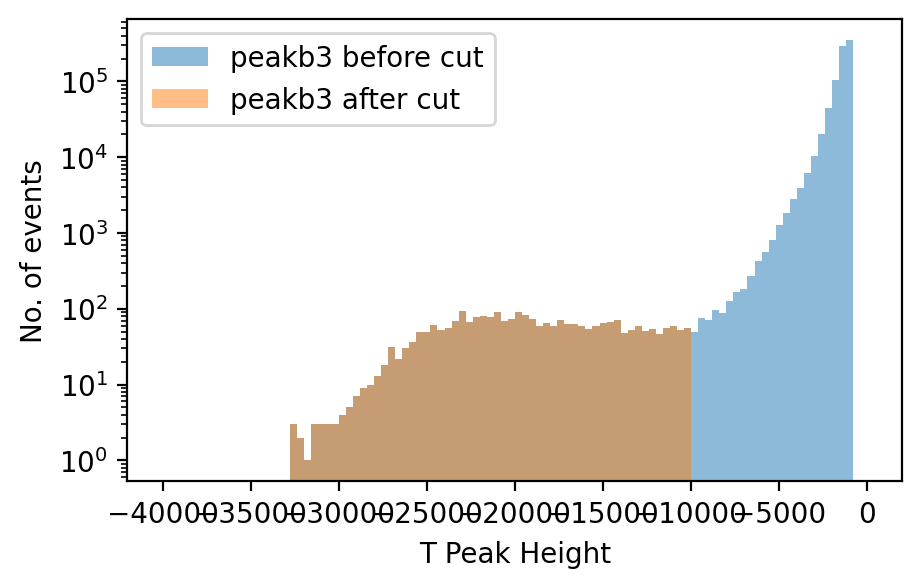

In [20]:
# Set very low (i.e. almost as if there is no cut)
PulseHeightThreshold = -10000

DFTcut6 = DFTcut5.loc[(DFTcut5['peakb3'] < PulseHeightThreshold)]     
DFScut6 = DFScut5.loc[(DFScut5['peakb3'] < PulseHeightThreshold)]
DFUcut6 = DFUcut5.loc[(DFUcut5['peakb3'] < PulseHeightThreshold)]

plt.figure(figsize=(5,3), dpi=200)

DFTcut5['peakb3'].plot.hist(bins=100, alpha=0.5, label='peakb3 before cut', range=[-40000.0,0.0], logy=True)
DFTcut6['peakb3'].plot.hist(bins=100, alpha=0.5, label='peakb3 after cut', range=[-40000.0,0.0], logy=True)

plt.xlabel('T Peak Height')
plt.ylabel('No. of events')
plt.legend()

print("Number of events before Cut6 (T):",len(DFTcut5))
print("Number of events before Cut6 (S):",len(DFScut5))
print("Number of events before Cut6 (U):",len(DFUcut5))
print("\n")
print("Number of events after Cut6 (T):",len(DFTcut6))
print("Number of events after Cut6 (S):",len(DFScut6))
print("Number of events after Cut6 (U):",len(DFUcut6))

DFTcut6.head()



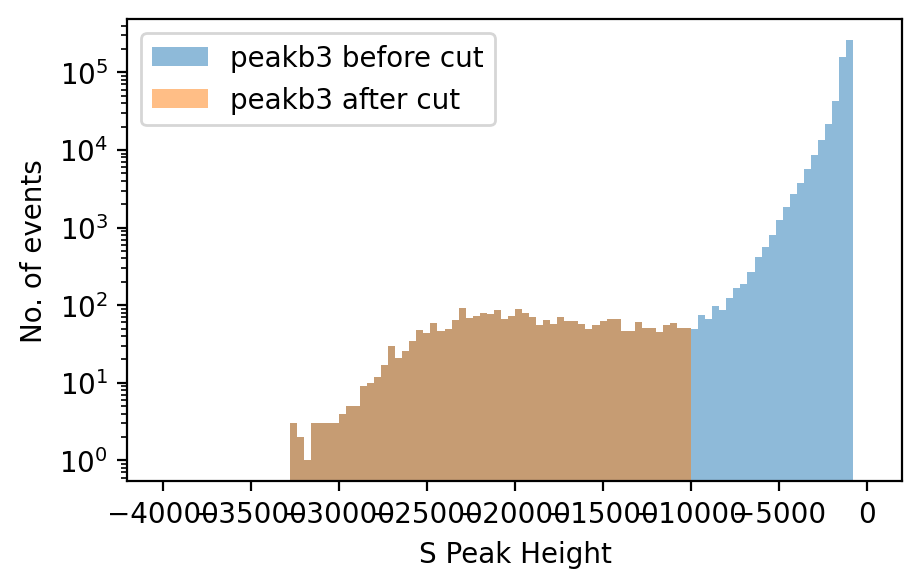

In [21]:
plt.figure(figsize=(5,3), dpi=200)

DFScut5['peakb3'].plot.hist(bins=100, alpha=0.5, label='peakb3 before cut', range=[-40000.0,0.0], logy=True)
DFScut6['peakb3'].plot.hist(bins=100, alpha=0.5, label='peakb3 after cut', range=[-40000.0,0.0], logy=True)

plt.xlabel('S Peak Height')
plt.ylabel('No. of events')
plt.legend()

### Extra plots

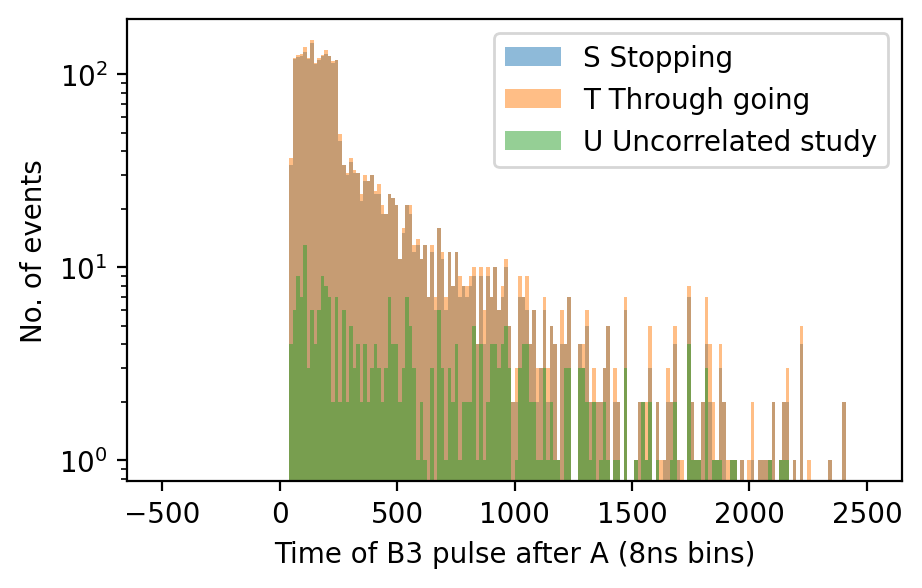

In [22]:
# and the time differences
plt.figure(figsize=(5,3), dpi=200)

DFScut6['delta_t_b3a1'].plot.hist(bins=200, range=[-500, 2500], alpha=0.5, label='S Stopping', logy=True)
DFTcut6['delta_t_b3a1'].plot.hist(bins=200, range=[-500, 2500], alpha=0.5, label='T Through going', logy=True)
DFUcut6['delta_t_b3a1'].plot.hist(bins=200, range=[-500, 2500], alpha=0.5, label='U Uncorrelated study', logy=True)

plt.xlabel('Time of B3 pulse after A (8ns bins)')
plt.ylabel('No. of events')
plt.legend()

### Note about the start time

In the above plot, we used A1 as the start time and B3 as the end time in our estimate of the lifetime of each muon.  Is A1 the best choice for the start time?  We are not sure.  It may be possible to get something with a better resolution using information from B1 and/or C1.


## Fitting

This is the last step and we haven't added anything to the template yet.  See the script for some simple ways to extract the lifetime from the time distribution.  Or you can take a look at the curve_fit programs in the scipy packages.